# Анализ игровых событий когорты пользователей мобильной игры в жанре "Три в ряд"

## Описание исходного датасета и добавление дополнительных столбцов для анализа

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#читаем датасет
data = pd.read_csv('testdataset - 2000 users.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127205 entries, 0 to 127204
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   EventTime   127205 non-null  int64 
 1   EventType   127205 non-null  object
 2   Registered  127205 non-null  int64 
 3   UserUID     127205 non-null  int64 
 4   UserSource  127205 non-null  object
 5   EventParam  127205 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.8+ MB


In [2]:
#приводим даты к читаемому виду
data['EventTime']= pd.to_datetime(data['EventTime'],unit='s')
data['Registered']= pd.to_datetime(data['Registered'],unit='s')
#добавляем дополнительные столбцы
data['DaysAfterRegister'] = (data['EventTime'] - data['Registered']).dt.days #количество дней с момента регистрации игрока
data['Day'] = data['EventTime'].dt.to_period("D") #день события
data['WeekDay'] = data['EventTime'].dt.day_name() #название дня недели события
data['Day_to_start'] = data['Day'].astype(int)-30819 #день события с момента старта когорты
data['Payment'] = data['EventParam']
data['Payment'] = pd.to_numeric(data['Payment'], errors = 'coerce') #размер платежа в числовом формате
#для события установка в зависимости от модели устройства в параметрах определяем платформу IOS, если IPhone или IPad, прочие Android
data['Platform'] = np.where(data['EventType']=='Install',np.where(data['EventParam'].str.contains('iPhone|iPad'),'IOS','Android'),0)
#создаем таблицу с присвоением каждому пользователю платформы далее будем объединять исходную с ней
user_platform_data = data.query('EventType == "Install"')[['UserUID','Platform']]
#удаляем ненужный столбец 
data = data.drop('Platform', axis = 1)
#для каждого события присваиваем платформу пользователя
data = data.merge(user_platform_data,on = 'UserUID',how = 'right')
#каждому событию пользователя присваиваем его порядковый номер для конкретного пользователя
data['EventNumber'] = 1
data.loc[data['EventType']=='FtueStep','EventNumber'] = data.loc[data['EventType']=='FtueStep'].groupby("UserUID").cumcount().add(1)
data.loc[data['EventType']=='Session','EventNumber'] = data.loc[data['EventType']=='Session'].groupby("UserUID").cumcount().add(1)
data.loc[data['EventType']=='InitPurchase','EventNumber'] = data.loc[data['EventType']=='InitPurchase'].groupby("UserUID").cumcount().add(1)
data.loc[data['EventType']=='Purchase','EventNumber'] = data.loc[data['EventType']=='Purchase'].groupby("UserUID").cumcount().add(1)

In [18]:
#строим сводную, чтобы понять насколько равномерно заходили пользователи когорты
install_data = data.query('EventType == "Install"')
install_pivot = install_data.pivot_table('UserUID','WeekDay',['UserSource','Platform'],aggfunc = 'count', margins = True)
print('Распределение пользователей когорты по \n платформам и дням недели, в которые было \n установлено приложение')
install_pivot.sort_values('All', ascending = False)

Распределение пользователей когорты по 
 платформам и дням недели, в которые было 
 установлено приложение


UserSource Organic      Traffic        All
Platform   Android  IOS Android  IOS      
WeekDay                                   
All            371  117    1104  408  2000
Tuesday         55   29     172   59   315
Wednesday       57   24     159   62   302
Saturday        49   16     162   58   285
Sunday          67   13     143   58   281
Thursday        55    8     163   51   277
Monday          42   13     158   60   273
Friday          46   14     147   60   267

- В течение недели установки происходили равномерно  
- 75% пришли по трафику  
- 74% пользователей играют на Android

## Метрики удержания. Tutorial Retention

Text(0.5, 1.0, 'Доля игроков дошедших до уровня')

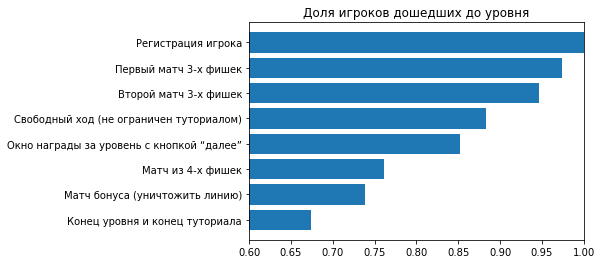

In [4]:
# считаем удержание для каждого шага обучения как отношение кол-ва уникальных пользователей на конкретном шаге к оьщему числу пользователей в когорте
Step_1_All_Retention = data.query('EventType == "FtueStep" & EventParam == "1"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_2_All_Retention = data.query('EventType == "FtueStep" & EventParam == "2"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_3_All_Retention = data.query('EventType == "FtueStep" & EventParam == "3"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_4_All_Retention = data.query('EventType == "FtueStep" & EventParam == "4"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_5_All_Retention = data.query('EventType == "FtueStep" & EventParam == "5"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_6_All_Retention = data.query('EventType == "FtueStep" & EventParam == "6"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_7_All_Retention = data.query('EventType == "FtueStep" & EventParam == "7"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Step_8_All_Retention = data.query('EventType == "FtueStep" & EventParam == "8"')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()

# задаем столбцы с данными для графика
steps_values = [Step_8_All_Retention,Step_7_All_Retention,Step_6_All_Retention,Step_5_All_Retention,Step_4_All_Retention,Step_3_All_Retention,Step_2_All_Retention,Step_1_All_Retention]
steps_names = ['Конец уровня и конец туториала','Матч бонуса (уничтожить линию)','Матч из 4-х фишек','Окно награды за уровень с кнопкой “далее”','Свободный ход (не ограничен туториалом)','Второй матч 3-х фишек','Первый матч 3-х фишек','Регистрация игрока']

# строим график
plt.barh(steps_names, steps_values)
plt.xlim([0.6,1])
plt.title('Доля игроков дошедших до уровня')

In [5]:
#строим сводную таблицу, в которой каждому пользователю сопоставляем время из шага обучения
Time_Tutorial_Steps = data.query('EventType =="FtueStep"').pivot_table('EventTime','UserUID','EventParam',aggfunc = 'min').reset_index()
#считаем сколько времени у пользователя занимает конкретный шаг обучения
Time_Tutorial_Steps['Step1Time'] = Time_Tutorial_Steps['2'] - Time_Tutorial_Steps['1']
Time_Tutorial_Steps['Step2Time'] = Time_Tutorial_Steps['3'] - Time_Tutorial_Steps['2']
Time_Tutorial_Steps['Step3Time'] = Time_Tutorial_Steps['4'] - Time_Tutorial_Steps['3']
Time_Tutorial_Steps['Step4Time'] = Time_Tutorial_Steps['5'] - Time_Tutorial_Steps['4']
Time_Tutorial_Steps['Step5Time'] = Time_Tutorial_Steps['6'] - Time_Tutorial_Steps['5']
Time_Tutorial_Steps['Step6Time'] = Time_Tutorial_Steps['7'] - Time_Tutorial_Steps['6']
Time_Tutorial_Steps['Step7Time'] = Time_Tutorial_Steps['8'] - Time_Tutorial_Steps['7']
#описываем полученные результаты
Time_Tutorial_Steps.describe()

EventParam       UserUID                  Step1Time  \
count       2.000000e+03                       1947   
mean        5.579851e+11  0 days 00:00:15.294298921   
std         2.549531e+11  0 days 00:00:06.056702211   
min         1.125084e+11            0 days 00:00:02   
25%         3.409403e+11            0 days 00:00:10   
50%         5.599121e+11            0 days 00:00:16   
75%         7.824214e+11            0 days 00:00:21   
max         9.996244e+11            0 days 00:00:25   

EventParam                  Step2Time                  Step3Time  \
count                            1893                       1767   
mean        0 days 00:00:14.809825673  0 days 00:00:14.849462365   
std         0 days 00:00:06.217666351  0 days 00:00:06.126819280   
min                   0 days 00:00:02            0 days 00:00:02   
25%                   0 days 00:00:10            0 days 00:00:10   
50%                   0 days 00:00:15            0 days 00:00:15   
75%                   0 days 00:00:20            0 days 00:00:20   
max                   0 days 00:00:25            0 days 00:00:25   

EventParam                  Step4Time                  Step5Time  \
count                            1705                       1523   
mean        0 days 00:00:15.023460410  0 days 00:00:14.915955351   
std         0 days 00:00:06.111976505  0 days 00:00:06.162774639   
min                   0 days 00:00:02            0 days 00:00:02   
25%                   0 days 00:00:10            0 days 00:00:10   
50%                   0 days 00:00:15            0 days 00:00:15   
75%                   0 days 00:00:20            0 days 00:00:20   
max                   0 days 00:00:25            0 days 00:00:25   

EventParam                  Step6Time                  Step7Time  
count                            1477                       1349  
mean        0 days 00:00:15.165876777  0 days 00:00:15.461823573  
std         0 days 00:00:06.201579929  0 days 00:00:06.118833352  
min                   0 days 00:00:02            0 days 00:00:02  
25%                   0 days 00:00:10            0 days 00:00:11  
50%                   0 days 00:00:15            0 days 00:00:16  
75%                   0 days 00:00:21            0 days 00:00:21  
max                   0 days 00:00:25            0 days 00:00:25

Выводы по анализу Tutorial Retention когорты:  
- Наиболее проблемные шаги обучения: второй матч 3-х фишек (- 7% пользователей), окно награды с кнопкой далее (- 8% пользователей), матч бонуса (-6% пользователей)  
- По времени прохождения уровней выводов о сложности сделать нельзя, так как время прохождения всех уровней одинаково. В среднем пользователи тратят по 15 секунд на каждый шаг. 

Возможные пути улучшения метрики:
- Изучить уровень с наградой и кнопкой 'далее', возможно кнопка не видна пользователям
- Проверить корректность данных о времени прохождения шагов, возможно, что второй матч и матч бонуса имеют высокую сложность или наоборот очень легкие и снижают интерес к игре

## Метрики удержания. 1,7,28 Day Retention

In [6]:
#считаем Retention как отношение кол-ва уникальных пользователей на 1,7 или 28 день к числу пользователей когорты

print('Общее удержание:')

Day_1_All_Retention = data.query('DaysAfterRegister == 1')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Day_7_All_Retention = data.query('DaysAfterRegister == 7')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()
Day_28_All_Retention = data.query('DaysAfterRegister == 28')['UserUID'].nunique()/data.query('EventType == "Install"')['UserUID'].nunique()

print('Доля вернувшихся на следующий день после установки - {:.0%}'.format(Day_1_All_Retention))
print('Доля вернувшихся через неделю после установки - {:.0%}'.format(Day_7_All_Retention))
print('Доля вернувшихся через 4 недели после установки - {:.0%}'.format(Day_28_All_Retention))
print('---')

#в зависимости от источника считаем Retention пришедших по трафику и органически

print('Удержание по трафику:')

Day_1_Traffic_Retention = data.query('DaysAfterRegister == 1 & UserSource == "Traffic"')['UserUID'].nunique()/data.query('EventType == "Install" & UserSource == "Traffic"')['UserUID'].nunique()
Day_7_Traffic_Retention = data.query('DaysAfterRegister == 7 & UserSource == "Traffic"')['UserUID'].nunique()/data.query('EventType == "Install" & UserSource == "Traffic"')['UserUID'].nunique()
Day_28_Traffic_Retention = data.query('DaysAfterRegister == 28 & UserSource == "Traffic"')['UserUID'].nunique()/data.query('EventType == "Install" & UserSource == "Traffic"')['UserUID'].nunique()

print('Доля вернувшихся на следующий день после установки - {:.0%}'.format(Day_1_Traffic_Retention))
print('Доля вернувшихся через неделю после установки - {:.0%}'.format(Day_7_Traffic_Retention))
print('Доля вернувшихся через 4 недели после установки - {:.0%}'.format(Day_28_Traffic_Retention))
print('---')

print('Органическое удержание:')

Day_1_Organic_Retention = data.query('DaysAfterRegister == 1 & UserSource == "Organic"')['UserUID'].nunique()/data.query('EventType == "Install" & UserSource == "Organic"')['UserUID'].nunique()
Day_7_Organic_Retention = data.query('DaysAfterRegister == 7 & UserSource == "Organic"')['UserUID'].nunique()/data.query('EventType == "Install" & UserSource == "Organic"')['UserUID'].nunique()
Day_28_Organic_Retention = data.query('DaysAfterRegister == 28 & UserSource == "Organic"')['UserUID'].nunique()/data.query('EventType == "Install" & UserSource == "Organic"')['UserUID'].nunique()

print('Доля вернувшихся на следующий день после установки - {:.0%}'.format(Day_1_Organic_Retention))
print('Доля вернувшихся через неделю после установки - {:.0%}'.format(Day_7_Organic_Retention))
print('Доля вернувшихся через 4 недели после установки - {:.0%}'.format(Day_28_Organic_Retention))

Общее удержание:
Доля вернувшихся на следующий день после установки - 59%
Доля вернувшихся через неделю после установки - 47%
Доля вернувшихся через 4 недели после установки - 12%
---
Удержание по трафику:
Доля вернувшихся на следующий день после установки - 59%
Доля вернувшихся через неделю после установки - 48%
Доля вернувшихся через 4 недели после установки - 15%
---
Органическое удержание:
Доля вернувшихся на следующий день после установки - 56%
Доля вернувшихся через неделю после установки - 44%
Доля вернувшихся через 4 недели после установки - 5%


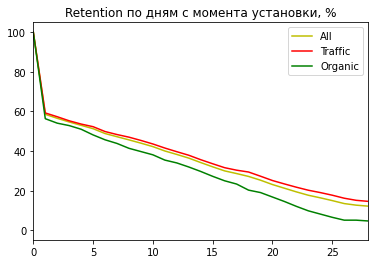

In [7]:
#группируем данные для построения графика
All_retention = data.groupby('DaysAfterRegister').agg({'UserUID':'nunique'})/data.query('EventType == "Install"')['UserUID'].nunique()
Traffic_retention = data.query('UserSource == "Traffic"').groupby('DaysAfterRegister').agg({'UserUID':'nunique'})/data.query('EventType == "Install" & UserSource == "Traffic"')['UserUID'].nunique()
Organic_retention = data.query('UserSource == "Organic"').groupby('DaysAfterRegister').agg({'UserUID':'nunique'})/data.query('EventType == "Install" & UserSource == "Organic"')['UserUID'].nunique()
# строим график
plt.plot(All_retention*100, label = 'All', color = 'y')
plt.plot(Traffic_retention*100, label ="Traffic", color = 'r')
plt.plot(Organic_retention*100, label ="Organic", color = 'g')
plt.xlim([0,28])
plt.title('Retention по дням с момента установки, %')
plt.legend()

Выводы по анализу Retention когорты:  
    - В первый день самая высокая доля "отвалившихся" пользователей 41%  
    - Удержание клиентов пришедших по трафику лучше органических установок.  
    - Если сравнить метрики с классическим правилом 40/20/10 на 1.7.28 день соответственно с бенчмарком (GameAnalytics BenchMark Reports 2017) для данного жанра 7% удержание 7-го дня, то можем сделать вывод о том, что в целом по метрикам удержания все не плохо.   
    Проблемы наблюдаются после первой недели, возможно, что пользователям становится скучно или они просто проходят все этапы, без дополнительный вводных не определить.

## Средняя продолжительность жизни пользователя в проекте (LifeTime) 

In [8]:
#для каждого пользователя находим событие с максимальным количеством дней, прошедших с момента регистрации. Далее находим среднее значение по пользователям.
LT_All = data.groupby('UserUID').agg({'DaysAfterRegister':'max'})['DaysAfterRegister'].mean()
LT_Traffic = data.query('UserSource == "Traffic"').groupby('UserUID').agg({'DaysAfterRegister':'max'})['DaysAfterRegister'].mean()
LT_Organic = data.query('UserSource == "Organic"').groupby('UserUID').agg({'DaysAfterRegister':'max'})['DaysAfterRegister'].mean()
print('Средняя продолжительность жизни пользователей этой когорты в проекте - {:.1f} дней'.format(LT_All))
print('Средняя продолжительность жизни пользователей, пришедших из трафика - {:.1f} дней'.format(LT_Traffic))
print('Средняя продолжительность жизни пользователей, пришедших органически - {:.1f} дней'.format(LT_Organic))

Средняя продолжительность жизни пользователей этой когорты в проекте - 10.8 дней
Средняя продолжительность жизни пользователей, пришедших из трафика - 11.6 дней
Средняя продолжительность жизни пользователей, пришедших органически - 8.5 дней


Продолжительность жизни  в проекте пользователей из трафика в среднем на 3 дня больше чем у пришедших органически.  Интересно, приносят ли они больше денег?

## Метрики монетизации

In [9]:
Revenue = data.query('EventType == "Purchase"')['Payment'].sum() #выручка как сумма всех платежей
ARPU = Revenue/data['UserUID'].nunique() #средний доход с одного пользователя из когорты
PayingShare = data.query('EventType == "Purchase"')['UserUID'].nunique()/data['UserUID'].nunique() #доля платящих игроков
ARPPU = Revenue/PayingShare/data['UserUID'].nunique() #средний доход с одного платящего пользователя из когорты
Avg_Check = Revenue/data.query('EventType == "Purchase"')['Payment'].count()
print('Выручка когорты за 2 месяца - {:.0f} USD'.format(Revenue))
print('Средний доход с одного пользователя - {:.2f} USD'.format(ARPU))
print('Доля платящих пользователей в когорте - {:.0%}'.format(PayingShare))
print('Средний доход с одного платящего пользователя - {:.2f} USD'.format(ARPPU))
print('Средний чек - {:.0f} USD'.format(Avg_Check))

Выручка когорты за 2 месяца - 5372 USD
Средний доход с одного пользователя - 2.69 USD
Доля платящих пользователей в когорте - 10%
Средний доход с одного платящего пользователя - 26.73 USD
Средний чек - 18 USD


Медианное значение ARPPU в жанре Puzzle в 2017 по данным GameAnalytics 6 USD, даже с учетом роста показателя за 4 года 27 USD хороший показатель  
ARPU и Paying Share значительно выше среднего по рынку.

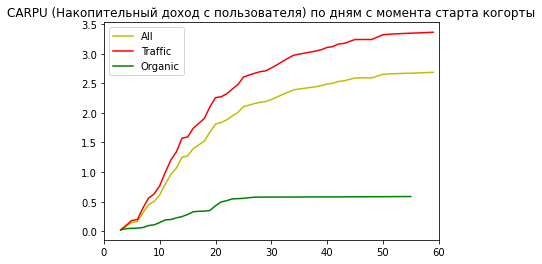

In [10]:
#считаем накопленную выручку с момента старта когорты в зависимости от типа трафика
All_Revenue = data.query('EventType == "Purchase"').groupby('Day_to_start').agg({'Payment':'sum'})
Traffic_Revenue = data.query('EventType == "Purchase" & UserSource == "Traffic"').groupby('Day_to_start').agg({'Payment':'sum'})
Organic_Revenue = data.query('EventType == "Purchase" & UserSource == "Organic"').groupby('Day_to_start').agg({'Payment':'sum'})

#считаем накопительный (Cumulative) средний доход с одного пользователя из когорты
All_CARPU = All_Revenue.cumsum()/data['UserUID'].nunique()
Traffic_CARPU = Traffic_Revenue.cumsum()/data.query('UserSource == "Traffic"')['UserUID'].nunique()
Organic_CARPU = Organic_Revenue.cumsum()/data.query('UserSource == "Organic"')['UserUID'].nunique()

#строим график
plt.plot(All_CARPU, label = 'All', color = 'y')
plt.plot(Traffic_CARPU, label ="Traffic", color = 'r')
plt.plot(Organic_CARPU, label ="Organic", color = 'g')
plt.xlim([0,60])
plt.title('CARPU (Накопительный доход с пользователя) по дням с момента старта когорты')
plt.legend()

- Пользователи пришедшие из трафика не только задерживаются в проекте дольше, но и в среднем приносят в 7 раз больше денег чем пришедшие органически.  
- Доход от пользователей пришедших органически перестал увеличиваться на 22-ой день, в то время как доход от пользователей трафика только на 50-ый

Доля платящих пользователей на Android в когорте - 10%
Доля платящих пользователей на IOS в когорте - 11%
Средний чек пользователей Android - 16 USD
Средний чек пользователей IOS- 23 USD


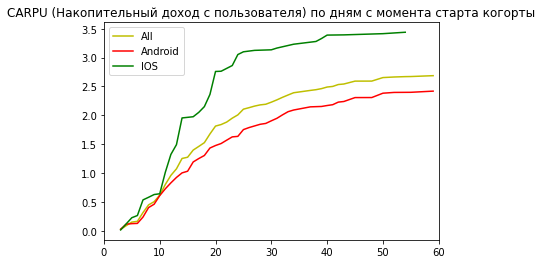

In [11]:
#считаем накопленную выручку с момента старта когорты в зависимости от платформы
All_Revenue = data.query('EventType == "Purchase"').groupby('Day_to_start').agg({'Payment':'sum'})
Android_Revenue = data.query('EventType == "Purchase" & Platform == "Android"').groupby('Day_to_start').agg({'Payment':'sum'})
IOS_Revenue = data.query('EventType == "Purchase" & Platform == "IOS"').groupby('Day_to_start').agg({'Payment':'sum'})

#считаем накопительный (Cumulative) средний доход с одного пользователя из когорты
All_CARPU = All_Revenue.cumsum()/data['UserUID'].nunique()
Android_CARPU = Android_Revenue.cumsum()/data.query('Platform == "Android"')['UserUID'].nunique()
IOS_CARPU = IOS_Revenue.cumsum()/data.query('Platform == "IOS"')['UserUID'].nunique()

#считаем долю платящих среди пользователей на Android и на IOS
PayingShare_Android = data.query('EventType == "Purchase" & Platform == "Android"')['UserUID'].nunique()/data.query('Platform == "Android"')['UserUID'].nunique()
PayingShare_IOS = data.query('EventType == "Purchase" & Platform == "IOS"')['UserUID'].nunique()/data.query('Platform == "IOS"')['UserUID'].nunique()

print('Доля платящих пользователей на Android в когорте - {:.0%}'.format(PayingShare_Android))
print('Доля платящих пользователей на IOS в когорте - {:.0%}'.format(PayingShare_IOS))

#считаем средний чек пользователей на Android и на IOS
Avg_Check_Android = data.query('EventType == "Purchase" & Platform == "Android"')['Payment'].sum()/data.query('EventType == "Purchase" & Platform == "Android"')['Payment'].count()
Avg_Check_IOS = data.query('EventType == "Purchase" & Platform == "IOS"')['Payment'].sum()/data.query('EventType == "Purchase" & Platform == "IOS"')['Payment'].count()

print('Средний чек пользователей Android - {:.0f} USD'.format(Avg_Check_Android))
print('Средний чек пользователей IOS- {:.0f} USD'.format(Avg_Check_IOS))

#строим график
plt.plot(All_CARPU, label = 'All', color = 'y')
plt.plot(Android_CARPU, label ="Android", color = 'r')
plt.plot(IOS_CARPU, label ="IOS", color = 'g')
plt.xlim([0,60])
plt.title('CARPU (Накопительный доход с пользователя) по дням с момента старта когорты')
plt.legend()

- Средний чек пользователей на IOS в 1,5 раз выше чем у пользователей Android
- Доля платящих пользователей на IOS выше чем на Android (11% против 10%)
- 80% дохода пользователей IOS было получено на второй и третей неделе (с 10 по 24-ый день)

Интересно, какая структура платящих пользователей и когда (вовремя какой сессии) игроки впервые совершают покупку и на какую сумму, как сумма платежа меняется в дальшейшем.

## Сегментация платящих пользователей

In [12]:
#группируем платежи по пользователям, сортируем по убыванию
Users_revenue = data.query('EventType == "Purchase"').groupby('UserUID').agg({'Payment':'sum'}).sort_values('Payment',ascending = False).reset_index()
#считаем долю в выручке по пользователям и долю накопительным итогом
Users_revenue['Revenue_Share'] = Users_revenue['Payment']/Revenue*100
Users_revenue['Cum_Revenue_Share_perc'] = round(Users_revenue['Revenue_Share'].cumsum(),1)
#задаем условия по доле в выручке в зависимости от них присваиваем пользователям сегмент
condition = [(Users_revenue['Cum_Revenue_Share_perc'] < 10),
            (Users_revenue['Cum_Revenue_Share_perc'] >= 10) & (Users_revenue['Cum_Revenue_Share_perc'] < 25),
            (Users_revenue['Cum_Revenue_Share_perc'] >= 25) & (Users_revenue['Cum_Revenue_Share_perc'] < 50),
            (Users_revenue['Cum_Revenue_Share_perc'] >= 50)] 
        
values = ['Whales','Grand Dolphins','Dolphins','Mirrows']

Users_revenue['segment'] = np.select(condition,values)
print(Users_revenue.groupby('segment').agg({'UserUID':'count','Cum_Revenue_Share_perc':'max'}).sort_values('UserUID'))
Users_revenue = Users_revenue.drop(['Payment','Revenue_Share','Cum_Revenue_Share_perc'],axis =1)
data = data.merge(Users_revenue, on = 'UserUID',how = 'left')
data['segment'] = data['segment'].fillna('Non-paying')

                UserUID  Cum_Revenue_Share_perc
segment                                        
Whales                3                     8.1
Grand Dolphins        8                    23.8
Dolphins             22                    49.7
Mirrows             168                   100.0


- 11 игроков "киты" и "крупные дельфины"(10% от всех платящих игроков) формируют 32% выручки.
- 84% платящих игроков "пескари" формируют 50% выручки.

## Анализ первой платящей сессии игроков

In [13]:
#считаем количество платежей за все время, которые сделали платящие игроки
Payments_numbers = data.query('EventType =="Purchase"').groupby('EventNumber').agg({'EventNumber':'count','Payment':'mean'})
print(round(Payments_numbers,0))

             EventNumber  Payment
EventNumber                      
1                    201     18.0
2                     83     18.0
3                      9     14.0
4                      5     29.0


- Средний чек не зависит от того первый платеж или повторный
- 95% платящих игроков сделали 1 или 2 платежа
- Больше 4-х платежей не сделал ни один игрок

<AxesSubplot:title={'center':'Большинство первых платежей (66%) совершаются в течение первых двух недель с момента установки'}>

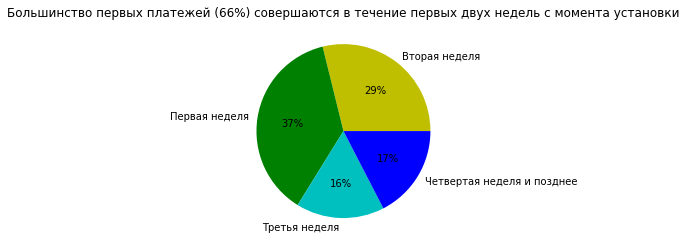

In [14]:
#группируем данные по количеству первых платежей в зависимости от дня с момента регистрации
FirstPaymentDay = data.query('EventType =="Purchase" & EventNumber == 1').groupby('DaysAfterRegister').agg({'Payment':'count'}).reset_index()
FirstPaymentDay['Share'] = round(FirstPaymentDay['Payment']/data.query('EventType =="Purchase" & EventNumber == 1')['Payment'].count()*100,1)
FirstPaymentDay['Cum_Share'] = FirstPaymentDay['Share'].cumsum()
#строим график распределения платежей по дням
condition1 = [(FirstPaymentDay['DaysAfterRegister'] < 7),
            (FirstPaymentDay['DaysAfterRegister'] >= 7) & (FirstPaymentDay['DaysAfterRegister'] < 14),
            (FirstPaymentDay['DaysAfterRegister'] >= 14) & (FirstPaymentDay['DaysAfterRegister'] < 21),
            (FirstPaymentDay['DaysAfterRegister'] >= 21)] 
        
values1 = ['Первая неделя','Вторая неделя','Третья неделя','Четвертая неделя и позднее']

colors = ['y','g','c','b']

FirstPaymentDay['week'] = np.select(condition1,values1)
FirstPaymentDay.groupby('week').agg({'Share':'sum'}).plot(kind='pie',y = 'Share',autopct='%1.0f%%', legend = False,  ylabel ='',colors = colors, title = 'Большинство первых платежей (66%) совершаются в течение первых двух недель с момента установки')

## Влияет ли частота использования приложения на монетизацию пользователя?

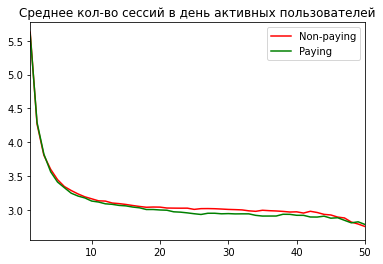

In [15]:
#группируем о накопленном количестве игровых сессий по дням с момента регистрации неплатящих пользователей:
DaySessionsNoPaid = data.query('EventType =="Session" & segment == "Non-paying"').groupby('DaysAfterRegister').agg({'EventNumber':'mean'}).reset_index()
#вычисляем среднее значение количества игорвых сессий в день
DaySessionsNoPaid['Avg_per_day']= DaySessionsNoPaid['EventNumber']/DaySessionsNoPaid['DaysAfterRegister']
#аналогично для платящих
DaySessionsPaid = data.query('EventType =="Session" & segment != "Non-paying"').groupby('DaysAfterRegister').agg({'EventNumber':'mean'}).reset_index()
DaySessionsPaid['Avg_per_day']= DaySessionsPaid['EventNumber']/DaySessionsPaid['DaysAfterRegister']
#строим график
plt.plot(DaySessionsNoPaid['Avg_per_day'], label = 'Non-paying', c = 'r')
plt.plot(DaySessionsPaid['Avg_per_day'], label = 'Paying', c = 'g')
plt.xlim([1,50])
plt.title('Среднее кол-во сессий в день активных пользователей')
plt.legend()

- Прямой корреляции между тем как часто игрок заходит в приложение и платит ли он нет, скорее наоборот с течением времени неплатящие игроки вынуждены заходить в приложение чаще ввиду более медленного игрового прогресса чем платящие